In [153]:
import pandas as pd 
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import power_anova 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statannot import add_stat_annotation
import sys
import os
import importlib
# Add the visualization module to the system path
src_path = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_path)

# Debug: Print the path being appended
print(f"Path added to sys.path: {src_path}")

# Debug: List the files in the src directory to ensure visualization.py is there
print(f"Files in src directory: {os.listdir(src_path)}")

# Import the plotting function and force reload
import visualization
importlib.reload(visualization)
from visualization import plot_freezing_time


Path added to sys.path: /Users/novak/Documents/Columbia/mentored_research/Turi/els git/els_project/notebooks/novak_analyses/../../src
Files in src directory: ['__init__.py', '__pycache__', 'visualization.py', 'readme.md', 'helper.py']


In [102]:
data = pd.read_csv('PTSD_filtered.csv')

#to create a varaible for age at sefla and consequently create a binary varaiable for young or not
data['dob'] = pd.to_datetime(data['dob'])
data['date'] = pd.to_datetime(data['date'])
data['age_at_sefla'] = None

for idx, row in data.iterrows():
    if row['day'] == 'sefla':
        data.at[idx, 'age_at_sefla'] = (row['date'] - row['dob']).days / 7
    else:
        sefla_row = data[(data['cohort_id'] == row['cohort_id']) & (data['day'] == 'sefla')]
        if not sefla_row.empty:
            data.at[idx, 'age_at_sefla'] = sefla_row.iloc[0]['age_at_sefla']

data['young'] = data['age_at_sefla'] < 12

/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_3211/4145871084.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['dob'] = pd.to_datetime(data['dob'])
/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_3211/4145871084.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


In [104]:
data['day'].value_counts()

day
sefla      74
seflb      74
recall1    74
recall2    74
recall3    74
recall4    73
recall5    57
Name: count, dtype: int64

In [105]:
#take out the sefla stage for better comparison between groups 
subset_data = data[(data['day'] != 'sefla') & (data['day'] != 'recall5')]
experimental_group = subset_data[subset_data['condition'] == 'sefl']
control_group = subset_data[subset_data['condition'] == 'control']

In [106]:
overall_condition = pg.mixed_anova(data=subset_data, dv='freezing', within='day', between='condition', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within between SEFL vs Control:")
print(overall_condition)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=overall_condition['np2'].iloc[0], k=2, power=0.80))

repeated ANOVA for Freezing Time within between SEFL vs Control:
        Source            SS  DF1  DF2            MS          F         p-unc  \
0    condition  28416.651469    1   71  28416.651469  45.675362  3.247348e-09   
1          day  16341.798900    4  284   4085.449725  35.458074  5.049349e-24   
2  Interaction   2881.865249    4  284    720.466312   6.253007  7.787397e-05   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.391474       NaN        NaN       NaN       NaN  
1  2.933725e-19  0.333071  0.830832      False  0.670803  0.000915  
2           NaN  0.080942       NaN        NaN       NaN       NaN  
The required sample size per group n: 7.2001


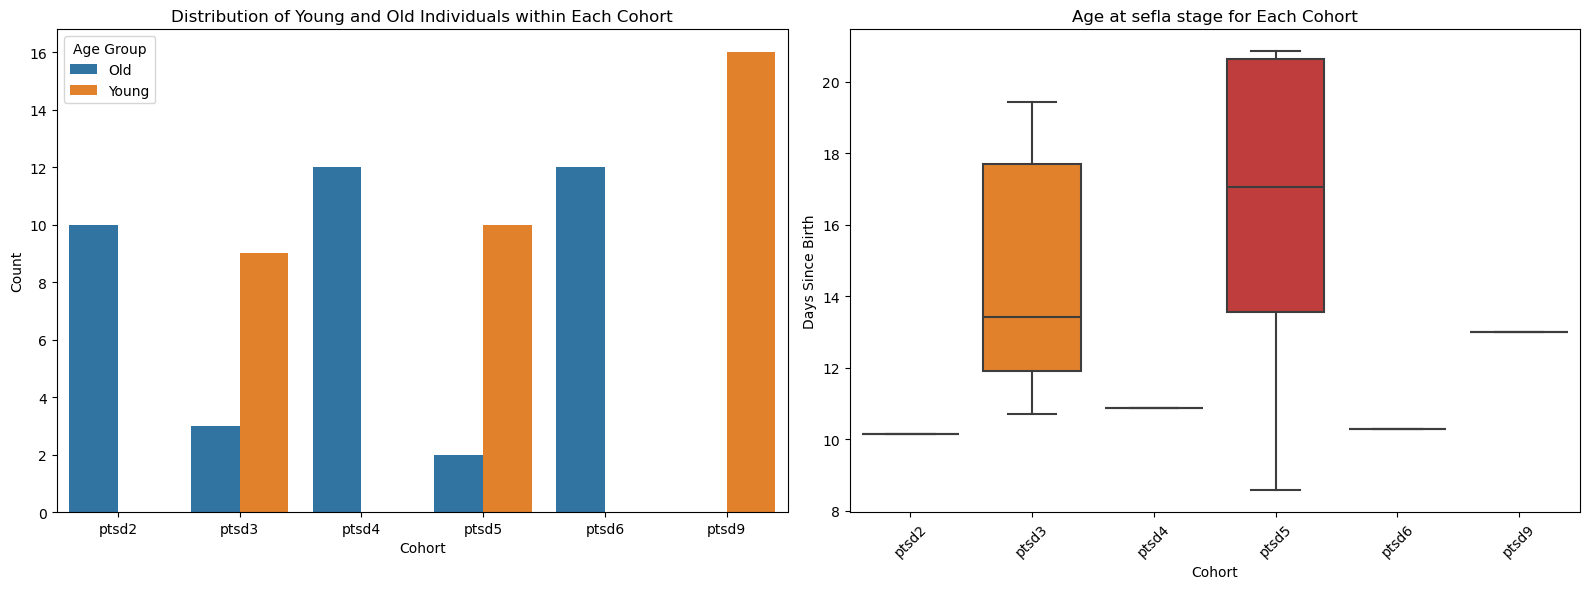

In [109]:
data_grouped = data.groupby('cohort_id').first().reset_index()

# Convert 'young' column to string type for plotting
data_grouped['young'] = data_grouped['young'].astype(str)

plt.figure(figsize=(16, 6))  

# Plot 1: Distribution of Young and Old Individuals within Each Cohort
plt.subplot(1, 2, 1)  # Create a subplot with 1 row, 2 columns, and select the first plot
sns.countplot(data=data_grouped, x='cohort', hue='young', order=sorted(data_grouped['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Count')
plt.title('Distribution of Young and Old Individuals within Each Cohort')
plt.legend(title='Age Group', labels=['Old', 'Young'])

# Plot 2: Days Since Birth for Each Cohort
plt.subplot(1, 2, 2)
sns.boxplot(data=data_grouped, x='cohort', y='age_at_sefla', order=sorted(data_grouped['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Days Since Birth')
plt.title('Age at sefla stage for Each Cohort')
plt.xticks(rotation=45)  
plt.tight_layout()  

In [5]:
# distribution for age and sex breakdown 
wrangled_data = subset_data.pivot(index='cohort_id', columns='day', values='freezing')
wrangled_data = wrangled_data.merge(subset_data[['condition', 'sex', 'cohort', 'young', 'cohort_id']].drop_duplicates('cohort_id'), on='cohort_id', how='left')
column_sequence = ['cohort_id', 'condition', 'seflb', 'recall1', 'recall2', 'recall3', 'recall4', 'recall5', 'sex', 'young', 'cohort']
wrangled_data = wrangled_data[column_sequence]
print(wrangled_data[wrangled_data['condition']=='sefl']['young'].value_counts())
print(wrangled_data[wrangled_data['condition']=='control']['young'].value_counts())
print(wrangled_data[wrangled_data['condition']=='sefl']['sex'].value_counts())
print(wrangled_data[wrangled_data['condition']=='control']['sex'].value_counts())


young
True     24
False    22
Name: count, dtype: int64
young
True     15
False    13
Name: count, dtype: int64
sex
male      30
female    16
Name: count, dtype: int64
sex
male      20
female     8
Name: count, dtype: int64


In [110]:
# ANOVA on freezing time between young and not young overall
overall_model_young = pg.mixed_anova(data=subset_data, dv='freezing', within='day', between='young', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between Young vs Not Young:")
print(overall_model_young)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=overall_model_young['np2'].iloc[0], k=2, power=0.80))

repeated ANOVA for Freezing Time between Young vs Not Young:
        Source            SS  DF1  DF2            MS          F         p-unc  \
0        young  17573.490042    1   71  17573.490042  22.679434  9.819557e-06   
1          day  16341.798900    4  284   4085.449725  34.110520  3.004565e-23   
2  Interaction   1589.155616    4  284    397.288904   3.317072  1.121206e-02   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.242096       NaN        NaN       NaN       NaN  
1  2.933725e-19  0.324521  0.830832      False  0.670803  0.000915  
2           NaN  0.044634       NaN        NaN       NaN       NaN  
The required sample size per group n: 13.3180


In [114]:
# ANOVA on freezing time between young and not young within experimental group
experimental_model_young = pg.mixed_anova(data=experimental_group, dv='freezing', within='day', between='young', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Experimental Group between Young vs Not Young:")
print(experimental_model_young)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=experimental_model_young['np2'].iloc[0], k=2, power=0.80))

# ANOVA on freezing time between young and not young within control group
control_model_young = pg.mixed_anova(data=control_group, dv='freezing', within='day', between='young', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Control Group between Young vs Not Young:")
print(control_model_young)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=control_model_young['np2'].iloc[0], k=2, power=0.80))

repeated ANOVA for Freezing Time within Experimental Group between Young vs Not Young:
        Source            SS  DF1  DF2            MS          F         p-unc  \
0        young  14113.431819    1   44  14113.431819  27.178746  4.752090e-06   
1          day  13935.939307    4  176   3483.984827  25.208874  1.617391e-16   
2  Interaction   1527.206691    4  176    381.801673   2.762581  2.917926e-02   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.381838       NaN        NaN       NaN       NaN  
1  5.696472e-14  0.364243  0.847872      False  0.617687  0.013086  
2           NaN  0.059077       NaN        NaN       NaN       NaN  
The required sample size per group n: 7.4480
repeated ANOVA for Freezing Time within Control Group between Young vs Not Young:
        Source           SS  DF1  DF2           MS          F         p-unc  \
0        young  2897.546971    1   25  2897.546971  16.796056  3.847635e-04   
1          day  5287.724841

In [115]:
old_data = subset_data[subset_data['young'] == False]
young_data = subset_data[subset_data['young'] == True]

# ANOVA on freezing between sefl and control within young mice 
young_model_condition = pg.mixed_anova(data=young_data, dv='freezing', within='day', between='condition', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between sefl and control within young mice:")
print(young_model_condition)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=young_model_condition['np2'].iloc[0], k=2, power=0.80))

# ANOVA on freezing between sefl and control within old mice 
old_model_condition = pg.mixed_anova(data=old_data, dv='freezing', within='day', between='condition', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between sefl and control within old mice:")
print(old_model_condition)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=old_model_condition['np2'].iloc[0], k=2, power=0.80))


repeated ANOVA for Freezing Time between sefl and control within young mice:
        Source            SS  DF1  DF2            MS          F         p-unc  \
0    condition  10275.082668    1   37  10275.082668  28.146426  5.473599e-06   
1          day   5555.644431    4  148   1388.911108  14.990470  2.615687e-10   
2  Interaction    766.865186    4  148    191.716296   2.069187  8.771580e-02   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.432049       NaN        NaN       NaN       NaN  
1  2.914427e-07  0.288331  0.645564      False  0.424123  0.000274  
2           NaN  0.052962       NaN        NaN       NaN       NaN  
The required sample size per group n: 6.2813
repeated ANOVA for Freezing Time between sefl and control within old mice:
        Source            SS  DF1  DF2            MS          F         p-unc  \
0    condition  17579.057548    1   32  17579.057548  41.198629  3.248600e-07   
1          day  12375.310085    4  128  

In [116]:
# ANOVA on freezing between male and female within young mice 
young_model_sex = pg.mixed_anova(data=young_data, dv='freezing', within='day', between='sex', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between male and female within young mice:")
print(young_model_sex)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=young_model_sex['np2'].iloc[0], k=2, power=0.80))

# ANOVA on freezing between male and female within old mice 
old_model_sex = pg.mixed_anova(data=old_data, dv='freezing', within='day', between='sex', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between male and female within old mice:")
print(old_model_sex)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=old_model_sex['np2'].iloc[0], k=2, power=0.80))

repeated ANOVA for Freezing Time between male and female within young mice:
        Source           SS  DF1  DF2           MS          F         p-unc  \
0          sex   306.939991    1   37   306.939991   0.483776  4.910628e-01   
1          day  5555.644431    4  148  1388.911108  15.663649  1.039987e-10   
2  Interaction  1356.195189    4  148   339.048797   3.823673  5.479817e-03   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.012906       NaN        NaN       NaN       NaN  
1  2.914427e-07  0.297428  0.645564      False  0.424123  0.000274  
2           NaN  0.093663       NaN        NaN       NaN       NaN  
The required sample size per group n: 301.1105
repeated ANOVA for Freezing Time between male and female within old mice:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          sex   2458.495949    1   32  2458.495949   2.734068  1.080075e-01   
1          day  12375.310085    4  128  3093.82752

In [117]:
# ANOVA on freezing time between male and female overall
overall_model_sex = pg.mixed_anova(data=subset_data, dv='freezing', within='day', between='sex', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between Male vs Female:")
print(overall_model_sex)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=overall_model_sex['np2'].iloc[0], k=2, power=0.80))

repeated ANOVA for Freezing Time between Male vs Female:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          sex   1351.904491    1   71  1351.904491   1.347407  2.496199e-01   
1          day  16341.798900    4  284  4085.449725  34.493103  1.806837e-23   
2  Interaction   1966.435508    4  284   491.608877   4.150612  2.772392e-03   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.018624       NaN        NaN       NaN       NaN  
1  2.933725e-19  0.326970  0.830832      False  0.670803  0.000915  
2           NaN  0.055231       NaN        NaN       NaN       NaN  
The required sample size per group n: 207.7578


In [119]:
# ANOVA on freezing time between sex within experimental group
experimental_model_sex = pg.mixed_anova(data=experimental_group, dv='freezing', within='day', between='sex', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Experimental Group between male vs female:")
print(experimental_model_sex)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=experimental_model_sex['np2'].iloc[0], k=2, power=0.80))

# ANOVA on freezing time between sex within control group
control_model_sex = pg.mixed_anova(data=control_group, dv='freezing', within='day', between='sex', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Control Group between male vs female:")
print(control_model_sex)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=control_model_sex['np2'].iloc[0], k=2, power=0.80))

repeated ANOVA for Freezing Time within Experimental Group between male vs female:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          sex   1075.794491    1   44  1075.794491   1.319035  2.569709e-01   
1          day  13935.939307    4  176  3483.984827  26.062773  5.610935e-17   
2  Interaction   2324.139067    4  176   581.034767   4.346568  2.236728e-03   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.029106       NaN        NaN       NaN       NaN  
1  5.696472e-14  0.371992  0.847872      False  0.617687  0.013086  
2           NaN  0.089904       NaN        NaN       NaN       NaN  
The required sample size per group n: 131.8773
repeated ANOVA for Freezing Time within Control Group between male vs female:
        Source           SS  DF1  DF2           MS          F         p-unc  \
0          sex     5.964670    1   25     5.964670   0.020698  8.867583e-01   
1          day  5287.724841    4  100

In [120]:
male_data = subset_data[subset_data['sex'] == 'male']
female_data = subset_data[subset_data['sex'] == 'female']

# ANOVA on freezing between sefl and control within male mice 
male_model_condition = pg.mixed_anova(data=male_data, dv='freezing', within='day', between='condition', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between sefl and control within male mice:")
print(male_model_condition)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=male_model_condition['np2'].iloc[0], k=2, power=0.80))

# ANOVA on freezing between sefl and control within female mice 
female_model_condition = pg.mixed_anova(data=female_data, dv='freezing', within='day', between='condition', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between sefl and control within female mice:")
print(female_model_condition)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=female_model_condition['np2'].iloc[0], k=2, power=0.80))



repeated ANOVA for Freezing Time between sefl and control within male mice:
        Source            SS  DF1  DF2            MS          F         p-unc  \
0    condition  16482.210628    1   47  16482.210628  33.027794  6.487305e-07   
1          day  12850.314396    4  188   3212.578599  29.390741  5.514595e-19   
2  Interaction   1965.331493    4  188    491.332873   4.495030  1.719086e-03   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.412704       NaN        NaN       NaN       NaN  
1  7.500404e-14  0.384742  0.735609      False  0.509582  0.000266  
2           NaN  0.087291       NaN        NaN       NaN       NaN  
The required sample size per group n: 6.6960
repeated ANOVA for Freezing Time between sefl and control within female mice:
        Source            SS  DF1  DF2            MS          F         p-unc  \
0    condition  11664.295510    1   22  11664.295510  13.068870  1.534631e-03   
1          day   5457.920012    4   88

In [9]:
male_data = subset_data[subset_data['sex'] == 'male']
female_data = subset_data[subset_data['sex'] == 'female']

# ANOVA on freezing between young and old within male mice 
male_model_age = pg.mixed_anova(data=male_data, dv='freezing', within='day', between='young', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between young and old within male mice:")
print(male_model_age)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=male_model_age['np2'].iloc[0], k=2, power=0.80))

# ANOVA on freezing between young and old within female mice 
female_model_age = pg.mixed_anova(data=female_data, dv='freezing', within='day', between='young', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time between young and old within female mice:")
print(female_model_age)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=female_model_age['np2'].iloc[0], k=2, power=0.80))



repeated ANOVA for Freezing Time between young and old within male mice:
        Source           SS  DF1  DF2           MS          F         p-unc  \
0        young  4700.247774    1   31  4700.247774   8.773650  5.821517e-03   
1          day  7479.354427    5  155  1495.870885  13.377002  7.663143e-11   
2  Interaction  2136.056429    5  155   427.211286   3.820387  2.722750e-03   

   p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0        NaN  0.220590       NaN        NaN       NaN       NaN  
1   0.000001  0.301440  0.565355      False  0.180141  0.000004  
2        NaN  0.109717       NaN        NaN       NaN       NaN  
The required sample size per group n: 14.8905
repeated ANOVA for Freezing Time between young and old within female mice:
        Source            SS  DF1  DF2            MS          F         p-unc  \
0        young  12423.849611    1   22  12423.849611  12.714061  1.728607e-03   
1          day   7166.580992    5  110   1433.316198  11.980039

In [124]:
data['time_in_day'] = [x[-2:] for x in data['time']]
data['time_in_day'] = data['time_in_day'].astype('category')

In [137]:
subset_data = data[(data['day'] != 'sefla') & (data['day'] != 'recall5')]
experimental_group = subset_data[subset_data['condition'] == 'sefl']
control_group = subset_data[subset_data['condition'] == 'control']

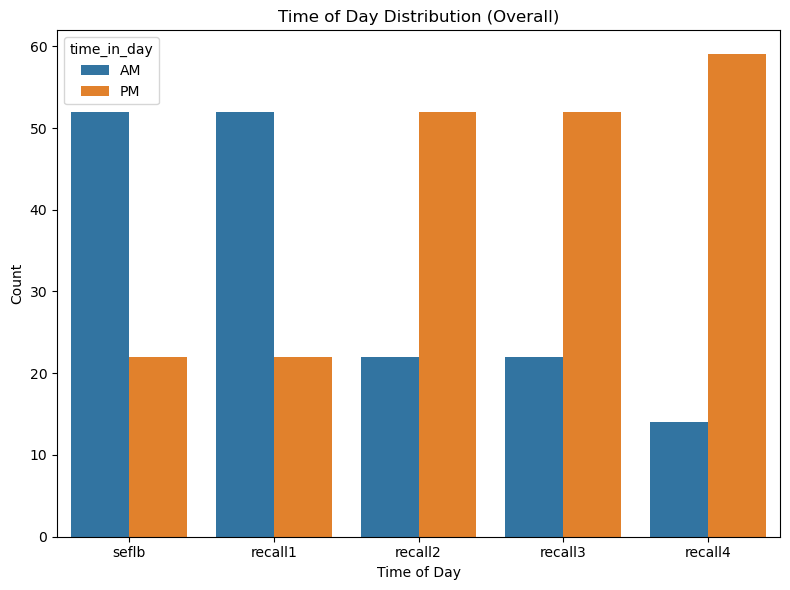

In [169]:
# Overall time of day distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=subset_data, x='day', hue='time_in_day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.title('Time of Day Distribution (Overall)')

plt.tight_layout()
plt.show()



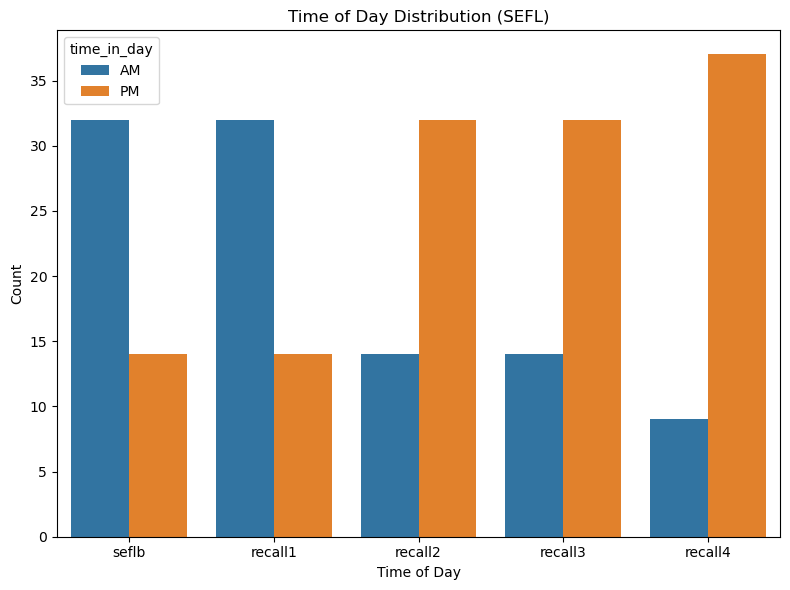

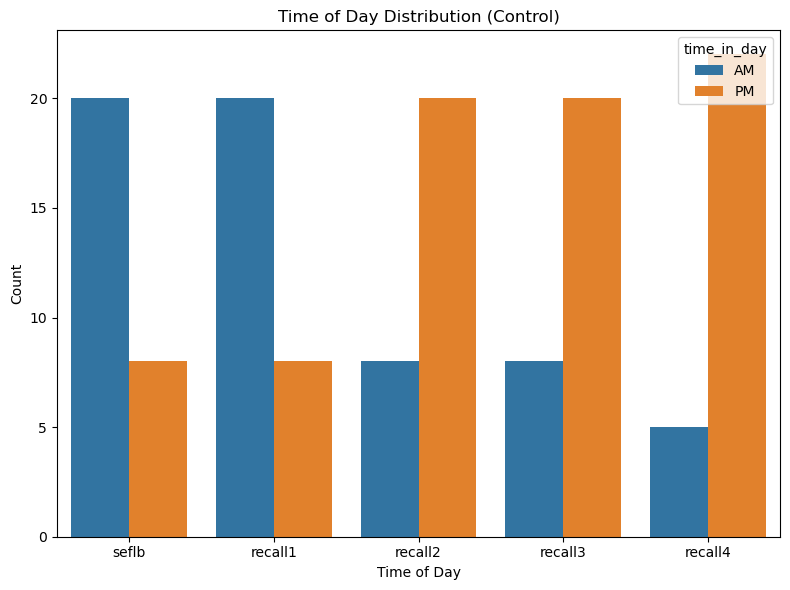

In [172]:
# Overall time of day distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=experimental_group, x='day', hue='time_in_day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.title('Time of Day Distribution (SEFL)')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.countplot(data=control_group, x='day', hue='time_in_day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.title('Time of Day Distribution (Control)')
plt.tight_layout()
plt.show()


In [155]:
#time of day analysis for sefl mice

seflb_experimental_group = experimental_group[experimental_group['day'] == 'seflb']
recall1_experimental_group = experimental_group[experimental_group['day'] == 'recall1']
recall2_experimental_group = experimental_group[experimental_group['day'] == 'recall2']
recall3_experimental_group = experimental_group[experimental_group['day'] == 'recall3']
recall4_experimental_group = experimental_group[experimental_group['day'] == 'recall4']

sefl_seflb_time = ols('freezing ~ C(time_in_day)', data=seflb_experimental_group).fit()
sefl_recall1_time = ols('freezing ~ C(time_in_day)', data=recall1_experimental_group).fit()
sefl_recall2_time = ols('freezing ~ C(time_in_day)', data=recall2_experimental_group).fit()
sefl_recall3_time = ols('freezing ~ C(time_in_day)', data=recall3_experimental_group).fit()
sefl_recall4_time = ols('freezing ~ C(time_in_day)', data=recall4_experimental_group).fit()

sefl_seflb_anova_table = sm.stats.anova_lm(sefl_seflb_time, typ=2)
sefl_recall1_anova_table = sm.stats.anova_lm(sefl_recall1_time, typ=2)
sefl_recall2_anova_table = sm.stats.anova_lm(sefl_recall2_time, typ=2)
sefl_recall3_anova_table = sm.stats.anova_lm(sefl_recall3_time, typ=2)
sefl_recall4_anova_table = sm.stats.anova_lm(sefl_recall4_time, typ=2)


anova_results = {
    'seflb': sefl_seflb_anova_table,
    'recall1': sefl_recall1_anova_table,
    'recall2': sefl_recall2_anova_table,
    'recall3': sefl_recall3_anova_table,
    'recall4': sefl_recall4_anova_table
}

p_values = {
    'seflb': anova_results['seflb']['PR(>F)'][0],
    'recall1': anova_results['recall1']['PR(>F)'][0],
    'recall2': anova_results['recall2']['PR(>F)'][0],
    'recall3': anova_results['recall3']['PR(>F)'][0],
    'recall4': anova_results['recall4']['PR(>F)'][0]
}

stages = ['seflb', 'recall1', 'recall2', 'recall3', 'recall4']
# Prepare the p-value list in the same order as box_pairs
p_values_list = [p_values[stage] for stage in stages]


/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_3211/1868667905.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'seflb': anova_results['seflb']['PR(>F)'][0],
/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_3211/1868667905.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'recall1': anova_results['recall1']['PR(>F)'][0],
/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_3211/1868667905.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

recall1_AM v.s. recall1_PM: Custom statistical test, P_val:2.276e-02
seflb_AM v.s. seflb_PM: Custom statistical test, P_val:5.622e-03
recall2_AM v.s. recall2_PM: Custom statistical test, P_val:1.184e-04
recall3_AM v.s. recall3_PM: Custom statistical test, P_val:2.992e-01
recall4_AM v.s. recall4_PM: Custom statistical test, P_val:2.678e-01


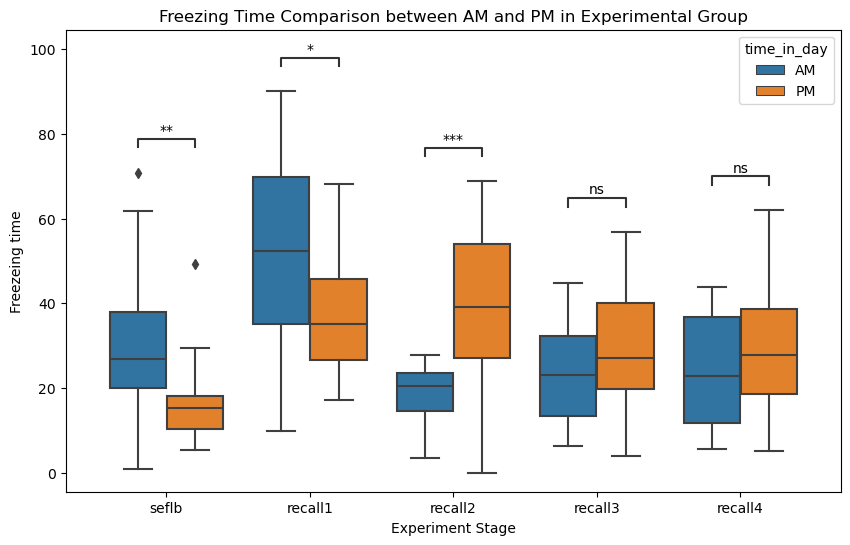

In [160]:
# time of day comparisons within sefl mice: recall 2-5 shows that pm has a higher freezing time than am, but not consistent with seflb and recall 1 stage 

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=experimental_group, x='day', y='freezing', hue='time_in_day')
plt.title('Freezing Time Comparison between AM and PM in Experimental Group')
plt.xlabel('Experiment Stage')
plt.ylabel('Freezeing time')


box_pairs = [
    (("seflb", "AM"), ("seflb", "PM")),
    (("recall1", "AM"), ("recall1", "PM")),
    (("recall2", "AM"), ("recall2", "PM")),
    (("recall3", "AM"), ("recall3", "PM")),
    (("recall4", "AM"), ("recall4", "PM"))
]

add_stat_annotation(
    ax,
    data=experimental_group,
    x='day',
    y='freezing',
    hue='time_in_day',
    box_pairs=box_pairs,
    perform_stat_test=False,
    pvalues=p_values_list,
    test_short_name='ANOVA',
    text_format='star',
    loc='inside',
    verbose=2
)

plt.show()

In [161]:
#time of day analysis for control mice

seflb_control_group = control_group[control_group['day'] == 'seflb']
recall1_control_group = control_group[control_group['day'] == 'recall1']
recall2_control_group = control_group[control_group['day'] == 'recall2']
recall3_control_group = control_group[control_group['day'] == 'recall3']
recall4_control_group = control_group[control_group['day'] == 'recall4']

control_seflb_time = ols('freezing ~ C(time_in_day)', data=seflb_control_group).fit()
control_recall1_time = ols('freezing ~ C(time_in_day)', data=recall1_control_group).fit()
control_recall2_time = ols('freezing ~ C(time_in_day)', data=recall2_control_group).fit()
control_recall3_time = ols('freezing ~ C(time_in_day)', data=recall3_control_group).fit()
control_recall4_time = ols('freezing ~ C(time_in_day)', data=recall4_control_group).fit()

control_seflb_anova_table = sm.stats.anova_lm(control_seflb_time, typ=2)
control_recall1_anova_table = sm.stats.anova_lm(control_recall1_time, typ=2)
control_recall2_anova_table = sm.stats.anova_lm(control_recall2_time, typ=2)
control_recall3_anova_table = sm.stats.anova_lm(control_recall3_time, typ=2)
control_recall4_anova_table = sm.stats.anova_lm(control_recall4_time, typ=2)


control_anova_results = {
    'seflb': control_seflb_anova_table,
    'recall1': control_recall1_anova_table,
    'recall2': control_recall2_anova_table,
    'recall3': control_recall3_anova_table,
    'recall4': control_recall4_anova_table
}

control_p_values = {
    'seflb': control_anova_results['seflb']['PR(>F)'][0],
    'recall1': control_anova_results['recall1']['PR(>F)'][0],
    'recall2': control_anova_results['recall2']['PR(>F)'][0],
    'recall3': control_anova_results['recall3']['PR(>F)'][0],
    'recall4': control_anova_results['recall4']['PR(>F)'][0]
}

stages = ['seflb', 'recall1', 'recall2', 'recall3', 'recall4']
# Prepare the p-value list in the same order as box_pairs
control_p_values_list = [control_p_values[stage] for stage in stages]


/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_3211/374828969.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'seflb': control_anova_results['seflb']['PR(>F)'][0],
/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_3211/374828969.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'recall1': control_anova_results['recall1']['PR(>F)'][0],
/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_3211/374828969.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavio

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

recall1_AM v.s. recall1_PM: Custom statistical test, P_val:1.728e-02
seflb_AM v.s. seflb_PM: Custom statistical test, P_val:2.668e-01
recall2_AM v.s. recall2_PM: Custom statistical test, P_val:1.670e-01
recall3_AM v.s. recall3_PM: Custom statistical test, P_val:4.193e-01
recall4_AM v.s. recall4_PM: Custom statistical test, P_val:5.734e-01


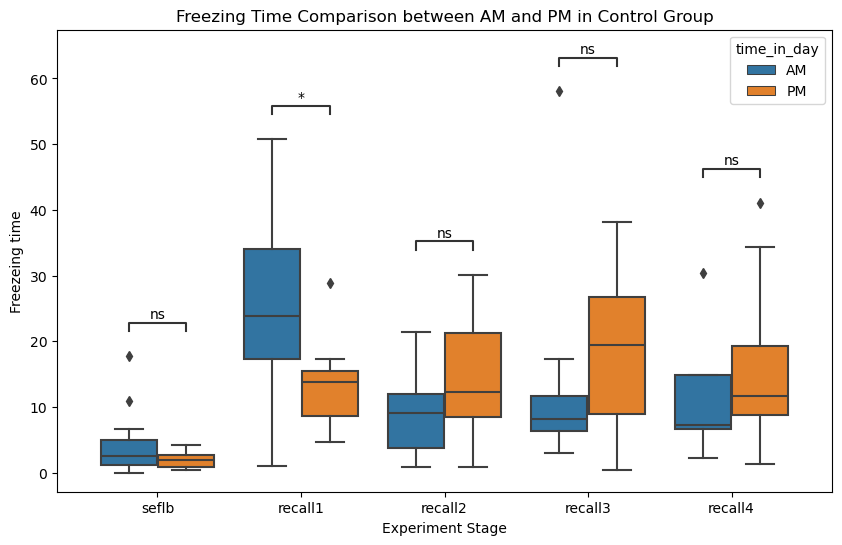

In [173]:
# time of day comparisons within control mice, which shows a similar pattern 
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=control_group, x='day', y='freezing', hue='time_in_day')
plt.title('Freezing Time Comparison between AM and PM in Control Group')
plt.xlabel('Experiment Stage')
plt.ylabel('Freezeing time')

box_pairs = [
    (("seflb", "AM"), ("seflb", "PM")),
    (("recall1", "AM"), ("recall1", "PM")),
    (("recall2", "AM"), ("recall2", "PM")),
    (("recall3", "AM"), ("recall3", "PM")),
    (("recall4", "AM"), ("recall4", "PM"))
]

add_stat_annotation(
    ax,
    data=control_group,
    x='day',
    y='freezing',
    hue='time_in_day',
    box_pairs=box_pairs,
    perform_stat_test=False,
    pvalues=control_p_values_list,
    test_short_name='ANOVA',
    text_format='star',
    loc='inside',
    verbose=2
)

plt.show()
